In [416]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from src.colnames import topic_col, emotion_col, style_col, exclude_col
import matplotlib.dates as md

### Structure
Content and narratives
- Topic modeling of EU Commission tweets
- Which topics generate most engagement (likes, comments, retweets, quotes)? 
- Which topics generate most positive comments? 
- Which narratives resonate the most?

Styles and emotional content

Predictive modeling
- Bag of words models
- Topic models
- Transformer-based models
- Style-based
- Sentiment-based

In [42]:
fs = glob.glob('data/derivatives/*')
dfs = []
for f in fs:
    d = pd.read_json(f, orient='records', lines=True)
    d['entity'] = '_'.join(f.split('/')[-1].split('.')[0].split('_')[:-1])
    dfs.append(d)

In [43]:
df = pd.concat(dfs, ignore_index=True)

## Style

#### Compare style variables across accounts

In [181]:
style_targets = [c for c in df.columns if any(['rauh' in c, 
                                               'benoit' in c, 
                                               'alpha_ratio' in c])]
sentiment_targets = [c for c in df.columns if 'sentiment' in c]

In [339]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

ests = []
for t in style_targets + sentiment_targets:
    data = df.rename({t: t.replace('-','_')}, axis=1).fillna(0)
    formula = f"{t.replace('-','_')} ~ C(entity, Treatment(reference='EU_Commission'))"
    
    # Specify model
    mod = smf.rlm(formula, data=data, M=sm.robust.norms.HuberT())
    
    # Freq workflow
    res = mod.fit()
    # print(f'\n{t}\n')
    # print(res.summary())
    
    # Save estimates
    est_df = pd.DataFrame(res.params, columns=['param'])
    est_df['predictor'] = est_df.index.str.replace(r"C\(entity, Treatment\(reference='EU_Commission'\)\)\[T\.", "", regex=True)
    est_df['predictor'] = est_df['predictor'].str.replace(r"\]", "", regex=True)
    est_df['target'] = t
    est_df['p_val'] = res.pvalues.values
    est_df = est_df.reset_index(drop=True)
    est_df = est_df[est_df['predictor']!='Intercept']
    ests.append(est_df)
    
# Make joint dataset
ests = pd.concat(ests)
conditions = [
    (ests["p_val"].lt(0.001)),
    (ests["p_val"].ge(0.001) & ests["p_val"].lt(0.01)),
    (ests["p_val"].ge(0.01) & ests["p_val"].lt(0.05)),
    (ests["p_val"].ge(0.05)),
]

choices = ["***", "**", "*", 'ns']
ests["p_val"] = np.select(conditions, choices)
ests['param_str'] =  '$' + ests['param'].round(2).astype(str) + '^{' + ests['p_val'] + '}$'

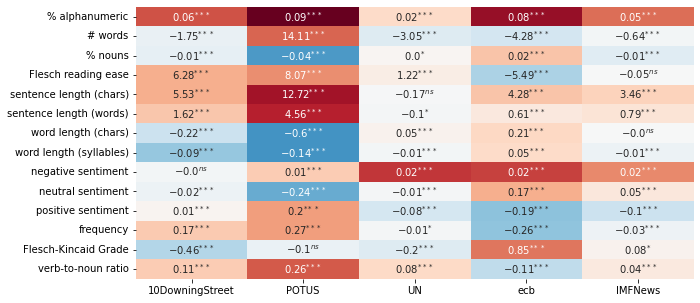

In [340]:
fig, ax = plt.subplots(figsize=(10,5))
wide_params = ests.pivot("target", "predictor", "param")
wide_params = wide_params[['10DowningStreet', 'POTUS', 'UN', 'ecb', 'IMFNews']]
wide_params.index = ['% alphanumeric', '# words', '% nouns', 'Flesch reading ease', 
                     'sentence length (chars)', 'sentence length (words)', 
                     'word length (chars)', 'word length (syllables)',
                     'negative sentiment', 'neutral sentiment', 'positive sentiment',
                     'frequency', 'Flesch-Kincaid Grade', 'verb-to-noun ratio']
annot = ests.pivot("target", "predictor", "param_str")
annot = annot[['10DowningStreet', 'POTUS', 'UN', 'ecb', 'IMFNews']]
annot.index = wide_params.index
sns.heatmap(wide_params/np.vstack([wide_params.std(axis=1).values]*5).T,
            cbar=False, cmap='RdBu_r', annot=annot, 
            fmt = '', center=0)
plt.xlabel('')
plt.show()

#### Overall style similarity

In [352]:
from sklearn.metrics.pairwise import pairwise_distances

dd = pd.DataFrame(pairwise_distances(df[style_targets + ['entity']].groupby('entity').mean()),
                  columns=df[style_col + ['entity']].groupby('entity').mean().index)
dd.index = dd.columns

In [378]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def _pca_transform(features):
    scaler = StandardScaler()
    X = scaler.fit_transform(features.fillna(0))
    pca = PCA(n_components=features.shape[1])
    pca.fit(X)
    new_feats = pca.transform(X)
    return new_feats

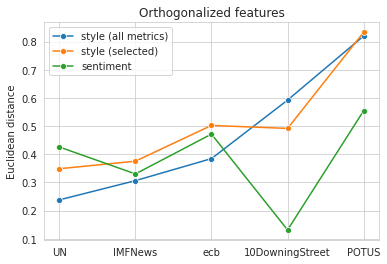

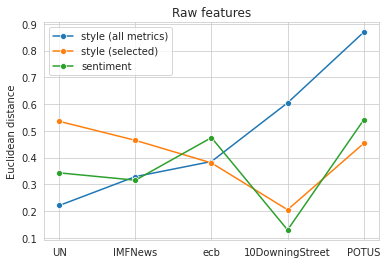

In [398]:
sns.set_style('whitegrid')
from sklearn.metrics.pairwise import pairwise_distances

for do_pca in [True, False]:
    for t, lab in zip([style_targets, style_col, sentiment_targets],
                      ['style (all metrics)', 'style (selected)', 'sentiment']):
        data = df.copy()
        if do_pca:
            data[t] = _pca_transform(data[t])
        dists = pairwise_distances(data[t + ['entity']].groupby('entity').mean())
        dd = pd.DataFrame(dists / dists.max(axis=1),
                          columns=data[t + ['entity']].groupby('entity').mean().index)
        dd.index = dd.columns
        sns.lineplot(data=dd.iloc[1, [0] + list(range(2,dd.shape[1]))].sort_values(), 
                     label=lab, marker='o')
    plt.title('Orthogonalized features' if do_pca is True else 'Raw features')
    plt.xlabel('')
    plt.ylabel('Euclidean distance')
    plt.show()

### Sentiment

In [412]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (23,5), 'W': (25,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}
colors = ['indianred', 'grey', sns.color_palette()[0]]


def plot_volume(freq='D', roll_window=7, outcomes=[], save=False, savename='sentiment_over_time',
                entity='EU_Commission', ylim=None):
    data = df[df['entity']==entity]
    fig, ax = plt.subplots(figsize=figsizes[freq])
    grouper = pd.Grouper(key='created_at', axis=0, freq=freq)
    grouped = data.groupby(grouper).mean().reset_index()
    for i,s in enumerate(outcomes):
        grouped[f'{s}_smoothed'] = grouped[s].rolling(roll_window,
                                                      min_periods=1).mean()
        sns.lineplot(data=grouped, 
                     x='created_at', 
                     y=s, 
                     alpha=.2,
                     color=colors[i])
        sns.lineplot(data=grouped, 
                     x='created_at', 
                     y=f'{s}_smoothed', 
                     label=s.replace('_',' ').capitalize(), 
                     color=colors[i])
    plt.ylabel(f'Score')
    plt.xlabel('')
    plt.title(f'{entity}')
    plt.xticks(rotation=60)
    # Make year boundaries
    for d in grouped.created_at.dt.year.unique():
        plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
        plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'),.97), color='black')
    ax.xaxis.set_major_locator(md.MonthLocator((1,7)))
    ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
    plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-09-01'))
    if ylim:
        plt.ylim(ylim)
    if save:
        plt.savefig(f'figs/{savename}.pdf')
    plt.show()

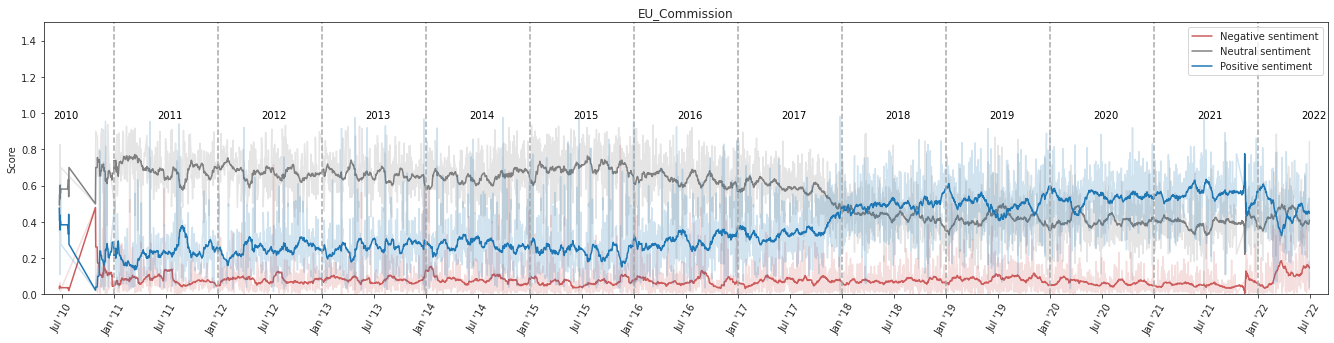

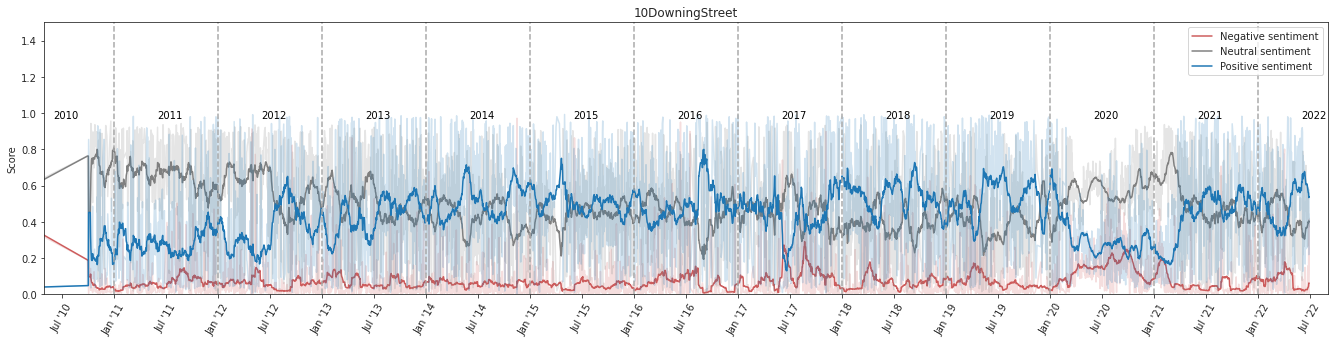

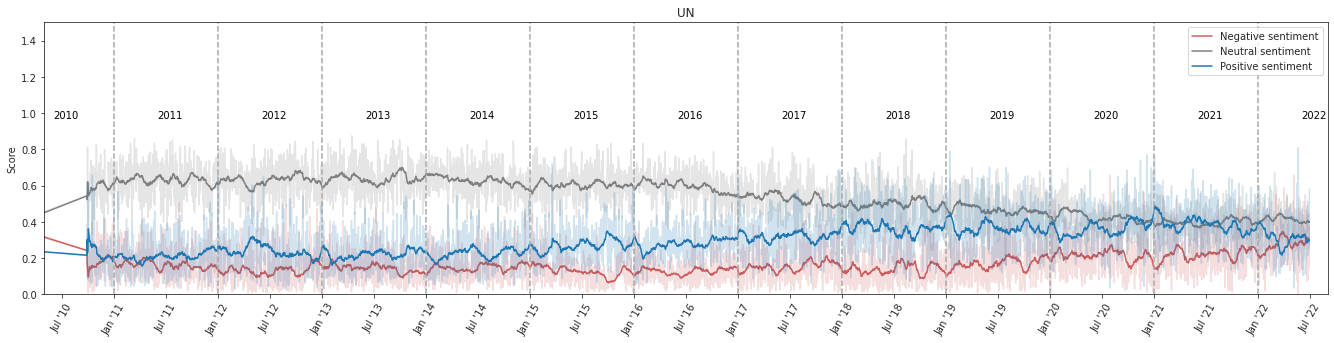

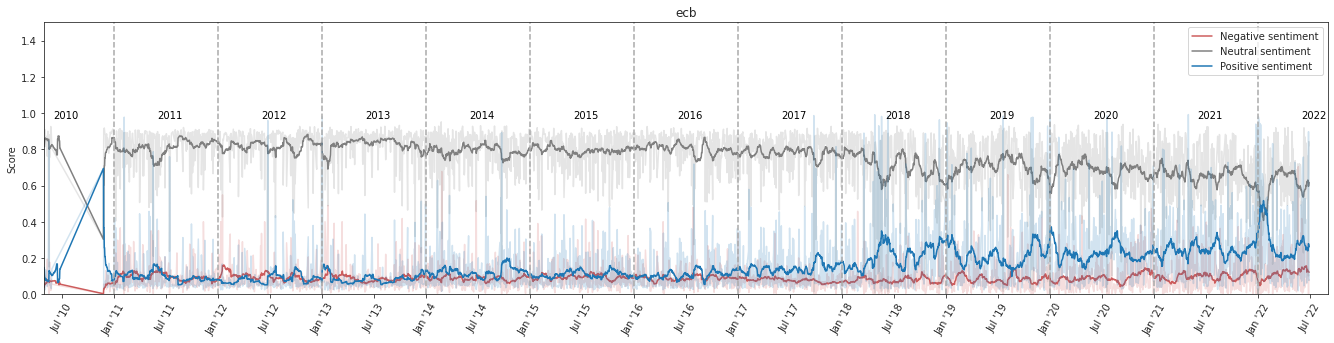

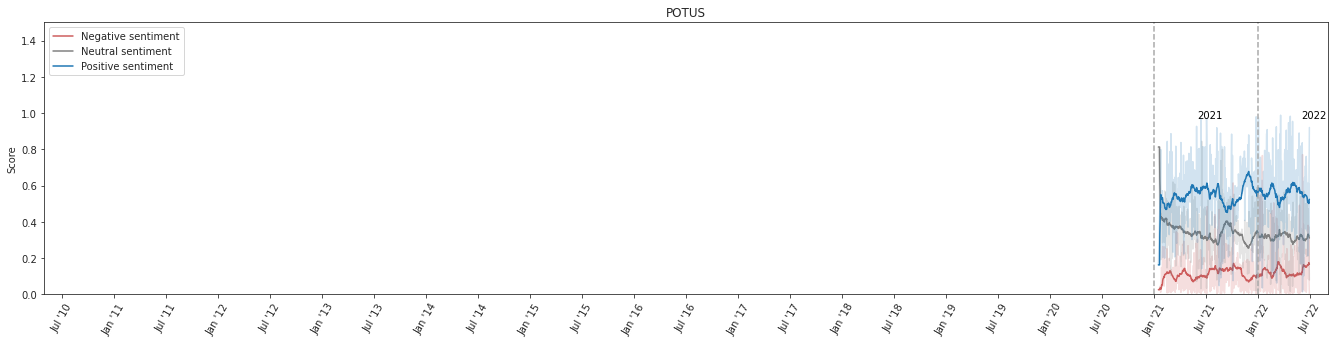

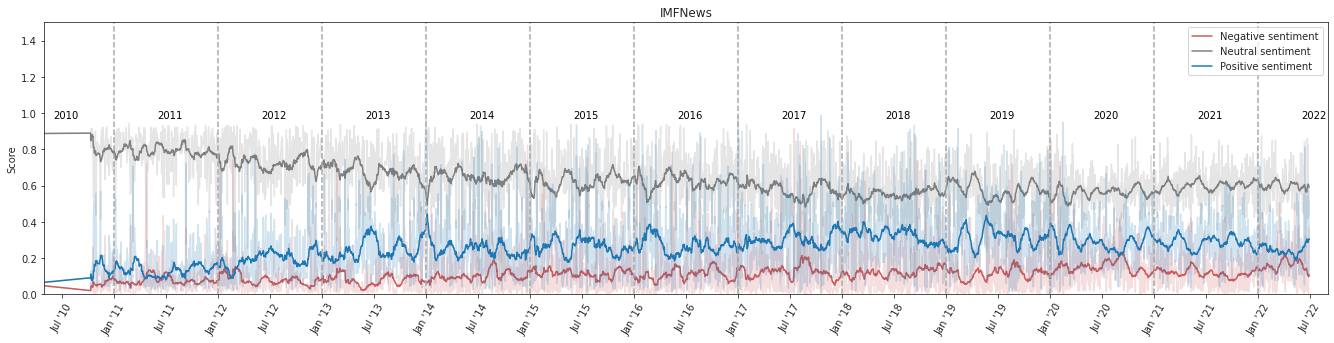

In [413]:
sns.set_style('ticks')
for entity in ['EU_Commission', '10DowningStreet', 'UN', 'ecb', 'POTUS', 'IMFNews']:
    plot_volume(freq='D',roll_window=30, outcomes=['negative_sentiment', 
                                                   'neutral_sentiment',
                                                   'positive_sentiment'], 
                save=False, savename='sentiment', entity=entity, ylim=(0,1.5))

### Results of predictive models

In [145]:
dfs = []
for metric in ['sum']:
    fs = glob.glob(f'logs/metrics/with_cv/{metric}_count/pred*.pkl')
    for f in fs:
        f_df = pd.read_pickle(f)
        f_df['metric'] = metric
        dfs.append(f_df)
    metrics = pd.concat(dfs, ignore_index=True)
    

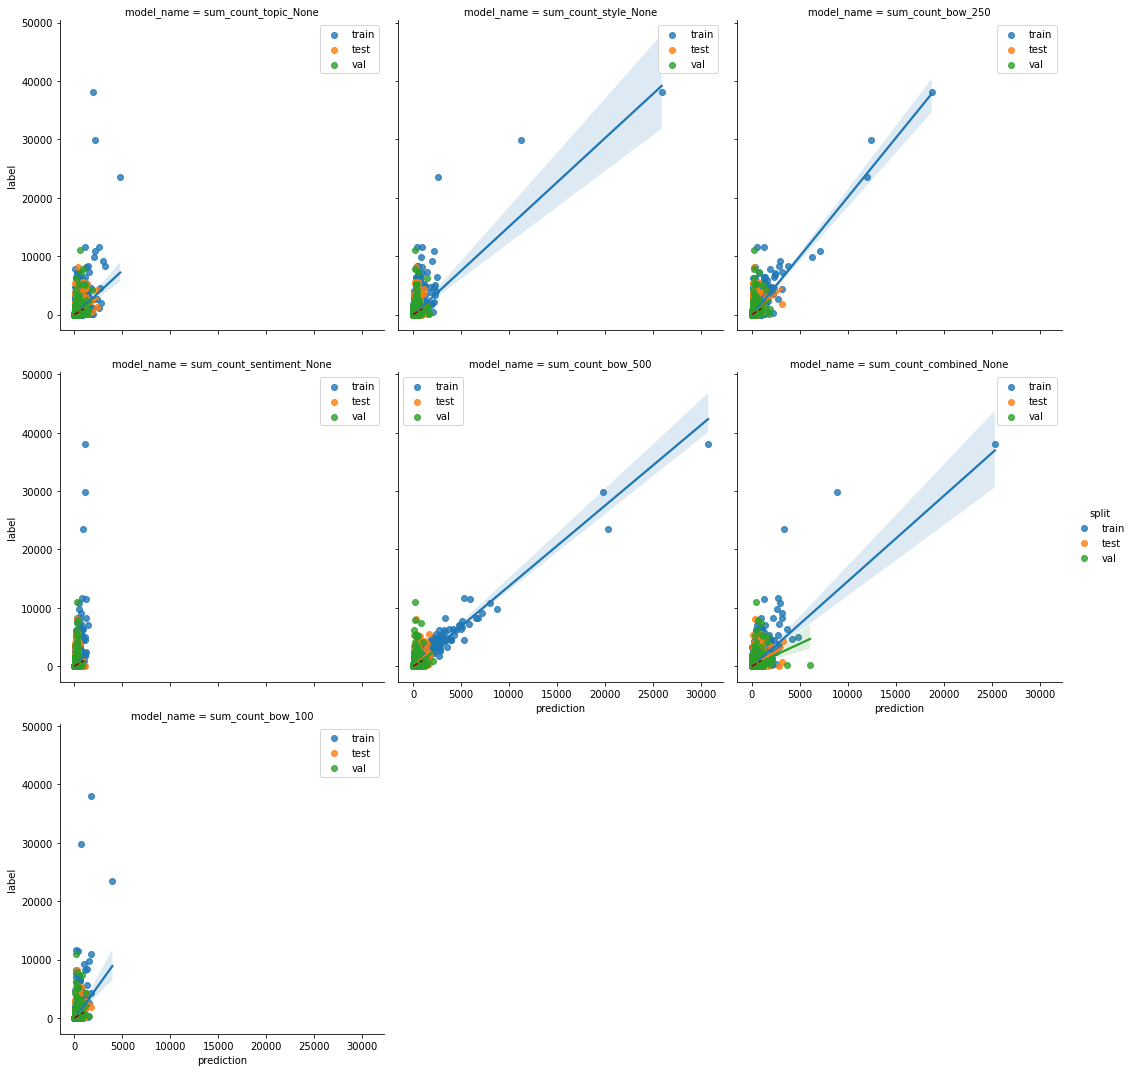

In [146]:
for metric in ['sum']:
    g = sns.lmplot(data=metrics[(metrics['split']=='test') & \
                                (metrics['metric']==metric)], 
                   x='prediction', y='label', 
                   hue='split',
                   col='model_name',
                   col_wrap=3)
    for a in g.axes:
        sns.lineplot(x=[1,500,1000], y=[1,500,1000], ax=a, 
                     color='darkred', linestyle='--')
    plt.show()

In [205]:
spears = metrics.groupby(['metric', 'split',
                 'model_name'])[['label', 'prediction']].apply(lambda x: x.corr('spearman').iloc[0,1]).reset_index()

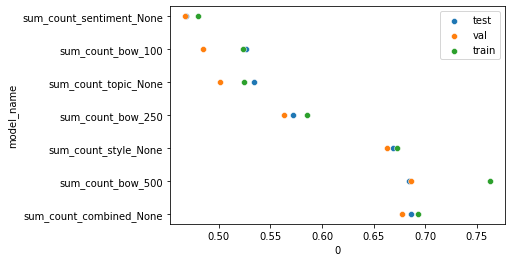

In [206]:
for metric in ['sum']:
    for out_metric in [0]:
        spears = spears.sort_values(by=out_metric, ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=spears[(spears['split']==split) & \
                                        (spears['metric']==metric)],
                            y='model_name', x=0, label=split)
        plt.show()

### Predictive models

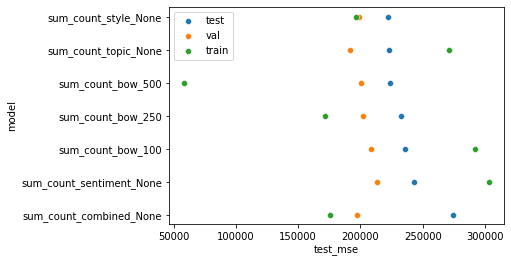

In [213]:
for metric in ['sum']:
    data = pd.DataFrame(json.load(open(f'logs/metrics/with_cv/{metric}_count.json')))
    for out_metric in ['mse']:
        data = data.sort_values(by=f'test_{out_metric}', ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=data, y='model', x=f'{split}_{out_metric}', label=split)
        plt.show()

***** sum *****


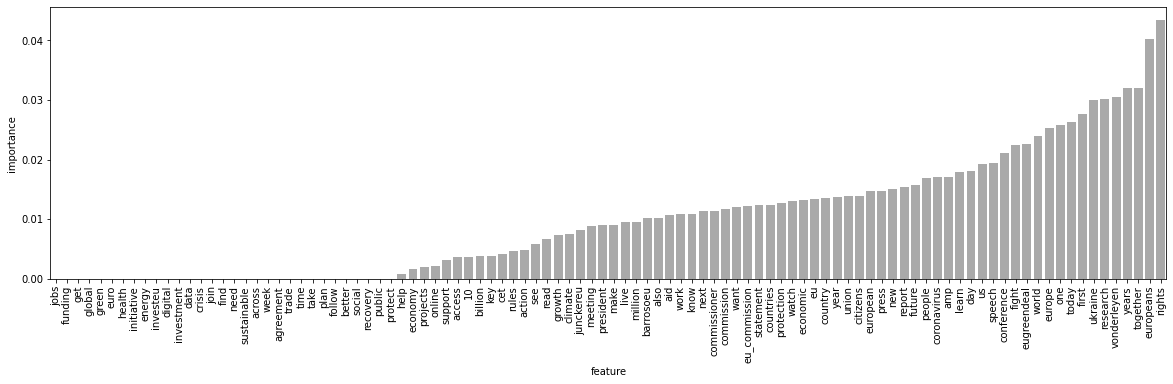

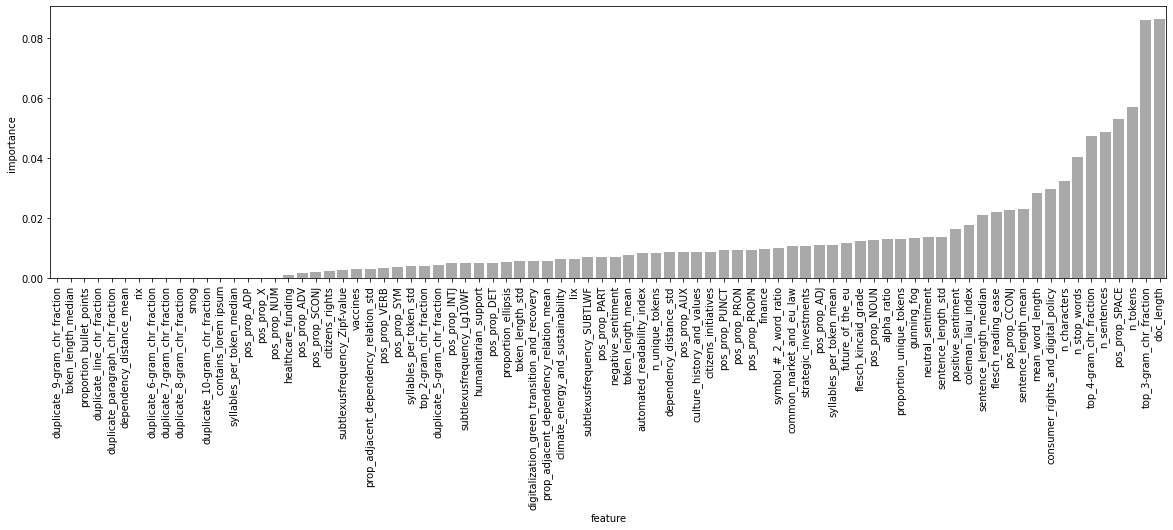

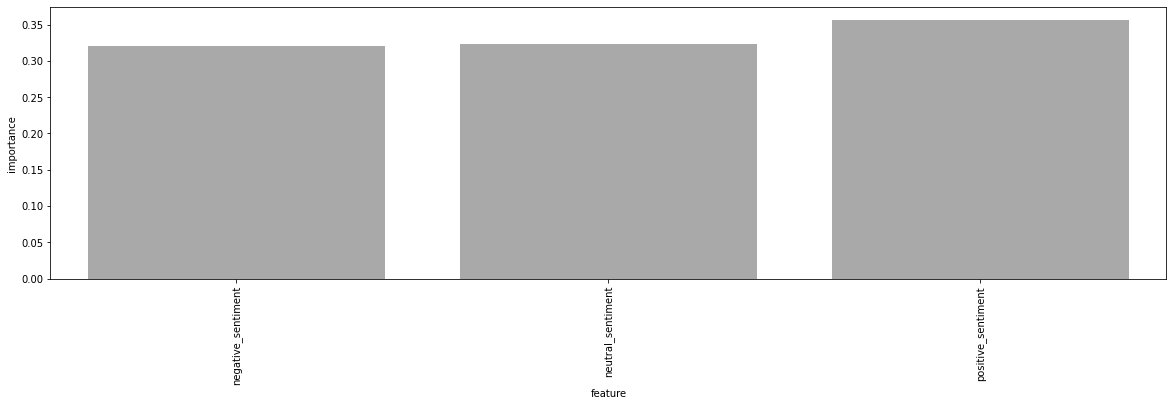

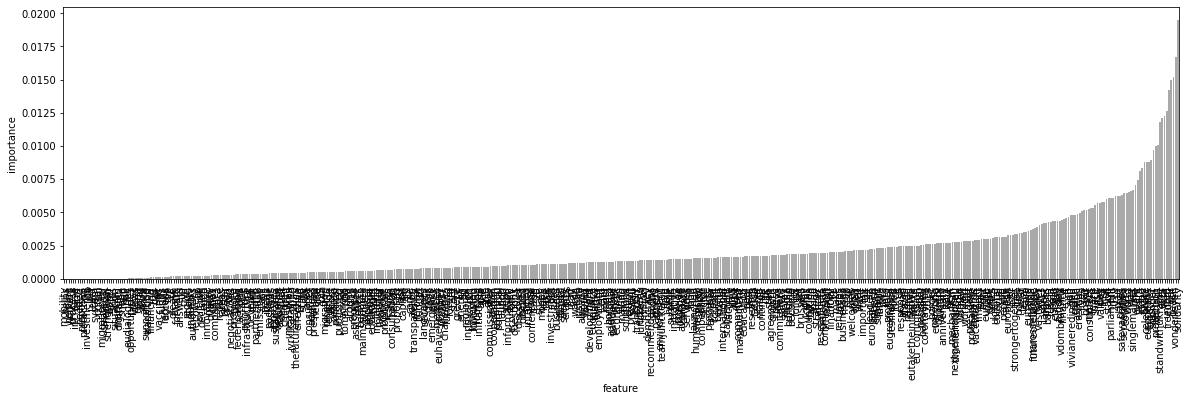

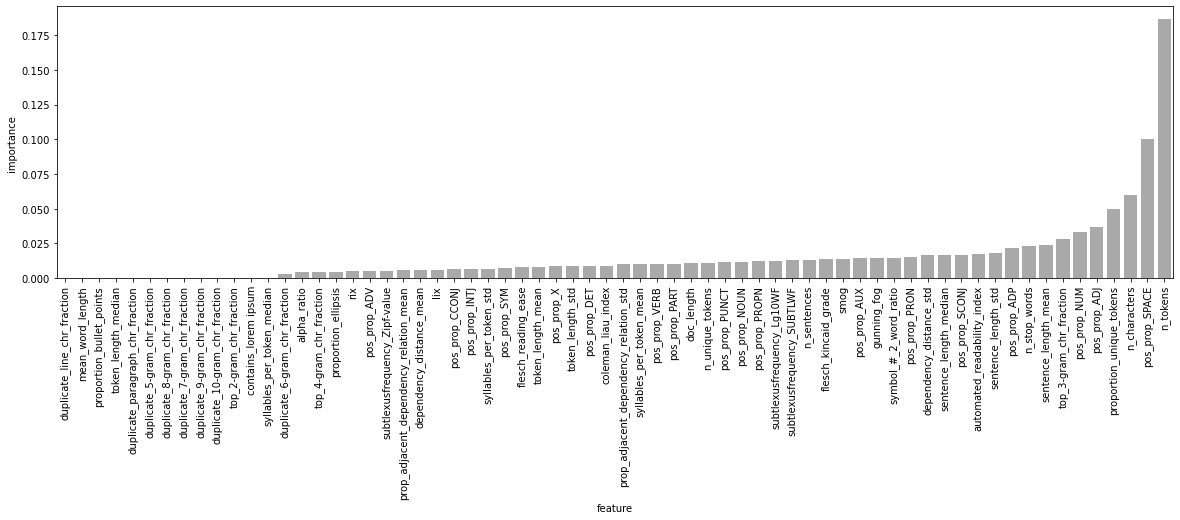

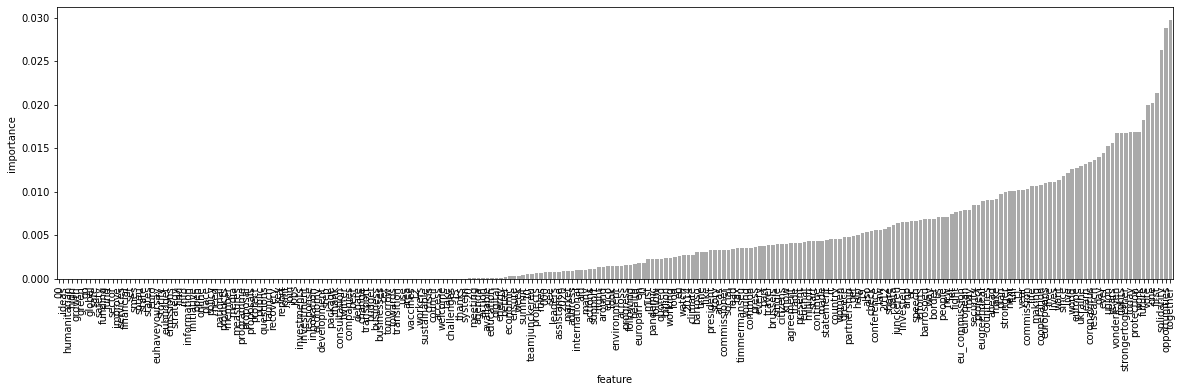

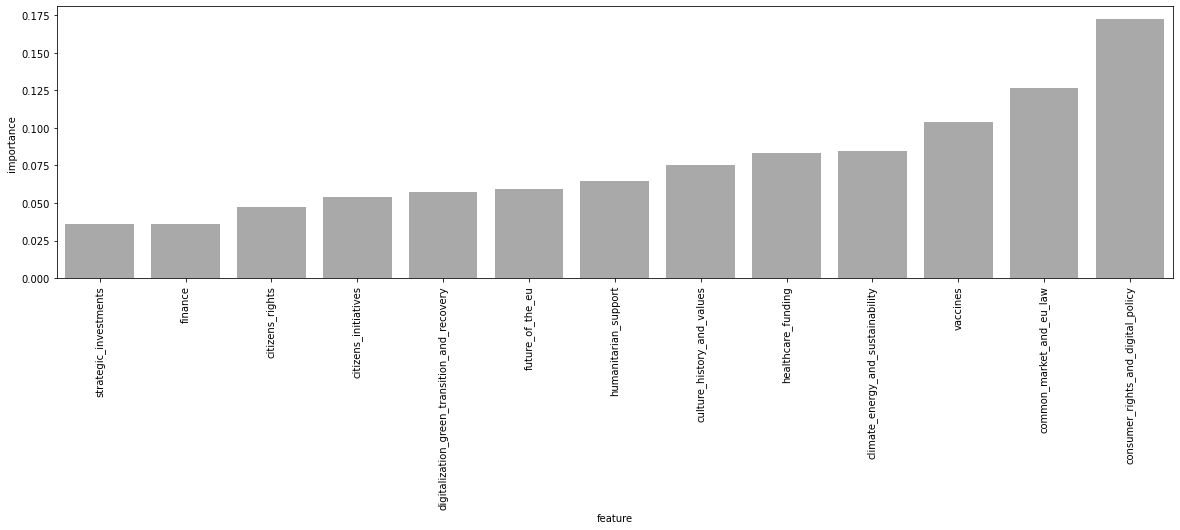

In [207]:
import pickle as pkl
import xgboost
import shap

with xgboost.config_context(verbosity=0):
    for metric in ['sum']:
        print(f'***** {metric} *****')
        fnames = glob.glob(f'logs/metrics/with_cv/{metric}_count/{metric}_count_*.pkl')
        for m in fnames:
            name = m.split('/')[-1]
            model = pkl.load(open(m, 'rb'))
            if 'topic' in m:
                feature_names = list(set(topic_col) - set(exclude_col))
            elif 'style' in m:
                feature_names = style_col
            elif 'combined' in m:
                feature_names = list(set(topic_col) - set(exclude_col)) + emotion_col + style_col 
            elif 'sentiment' in m:
                feature_names = emotion_col
            else:
                bow_nr = m.split('_')[-1].split('.')[0]
                tokenizer = pkl.load(open(f'logs/metrics/with_cv/{metric}_count/tokenizer_bow-{bow_nr}.pkl',
                                          'rb'))
                feature_names = tokenizer.get_feature_names()
                
            df = pd.DataFrame(zip(model.feature_importances_,
                                  feature_names), 
                              columns=['importance', 'feature'])
            df = df.sort_values(by='importance')
            plt.subplots(figsize=(20,5))
            sns.barplot(data=df, x='feature', y='importance', color='darkgrey')
            plt.xticks(rotation=90)
            plt.show()
            
           # shaps = pkl.load(open(f'logs/metrics/with_cv/{metric}_count/shap_{name}','rb'))
           # if not 'topic' in m:
           #     df = df.tail(n=50)
           #     fig, ax = plt.subplots(figsize=(20,4))    
           # shap.summary_plot(shaps, max_display=100, feature_names=feature_names)

    

In [164]:
for m in ['sum']:
    d = pd.read_csv(f'logs/metrics/with_cv/{m}_count/grid.csv').sort_values(by='mean_test_score',
                                                                    ascending=False)